In [1]:
import numpy as np 
import pandas as pd 
import os
import seaborn as sns 
import random
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import models
import torchvision.transforms as transforms
import torch.optim as optim
from skimage import io
import torch.nn.functional as F
import torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingLR

# Data preparation

In [2]:
train_dir='/kaggle/input/labeled-chest-xray-images/chest_xray/train'
test_dir='/kaggle/input/labeled-chest-xray-images/chest_xray/test'

In [3]:
# labeling the images into 3 classes instead of 2
# labels: 0-normal, 1-virus, 2-bacteria

train_labels={"filename":[], "label":[], "type":[], "binary class":[]}
test_labels={"filename":[], "label":[], "type":[], "binary class":[]}

for img_name in os.listdir(train_dir+"/NORMAL"):
    train_labels["filename"].append(img_name)
    train_labels["label"].append(0)
    train_labels["type"].append("normal")
    train_labels["binary class"].append("NORMAL")
    
for img_name in os.listdir(test_dir+"/NORMAL"):
    test_labels["filename"].append(img_name)
    test_labels["label"].append(0)
    test_labels["type"].append("normal")
    test_labels["binary class"].append("NORMAL")
    
for img_name in os.listdir(train_dir+"/PNEUMONIA"):
    if img_name[:1]=="V":
        train_labels["filename"].append(img_name)
        train_labels["label"].append(1)
        train_labels["type"].append("virus")
        train_labels["binary class"].append("PNEUMONIA")
    else:
        train_labels["filename"].append(img_name)
        train_labels["label"].append(2)
        train_labels["type"].append("bacteria")
        train_labels["binary class"].append("PNEUMONIA")
        
for img_name in os.listdir(test_dir+"/PNEUMONIA"):
    if img_name[:1]=="V":
        test_labels["filename"].append(img_name)
        test_labels["label"].append(1)
        test_labels["type"].append("virus")
        test_labels["binary class"].append("PNEUMONIA")
    else:
        test_labels["filename"].append(img_name)
        test_labels["label"].append(2)
        test_labels["type"].append("bacteria")
        test_labels["binary class"].append("PNEUMONIA")
        

train_data=pd.DataFrame.from_dict(train_labels)
train_data =train_data.assign(img_path=lambda x: train_dir +"/"+ x['binary class'] +"/"+ x['filename'])
#train_data.drop(labels=["binary class"], axis=1, inplace=True)
train_data.to_csv("train_labels.csv", index=False)

test_data=pd.DataFrame.from_dict(test_labels)
test_data =test_data.assign(img_path=lambda x: test_dir +"/"+ x['binary class'] +"/"+ x['filename'])
#test_data.drop(labels=["binary class"], axis=1, inplace=True)
test_data.to_csv("test_labels.csv", index=False)

In [4]:
label_count=train_data.groupby(by="type", as_index=False).count().sort_values(by="filename", ascending=False).reset_index(drop=True)
label_count_test=test_data.groupby(by="type", as_index=False).count().sort_values(by="filename", ascending=False).reset_index(drop=True)
print("Label distribution is train data: \n", label_count[["type", "filename"]], "\n")
print("Label distribution is test data: \n", label_count_test[["type", "filename"]])

Label distribution is train data: 
        type  filename
0  bacteria      2538
1    normal      1349
2     virus      1345 

Label distribution is test data: 
        type  filename
0  bacteria       242
1    normal       234
2     virus       148


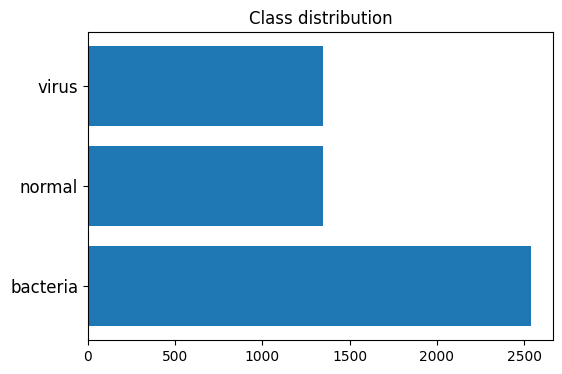

In [5]:
fig, ax = plt.subplots(figsize=(6, 4))
ax=plt.barh(label_count["type"], label_count["filename"])
plt.title("Class distribution")
plt.xticks(fontsize = 10) 
plt.yticks(["bacteria", "normal", "virus"], fontsize = 12) 
plt.show()

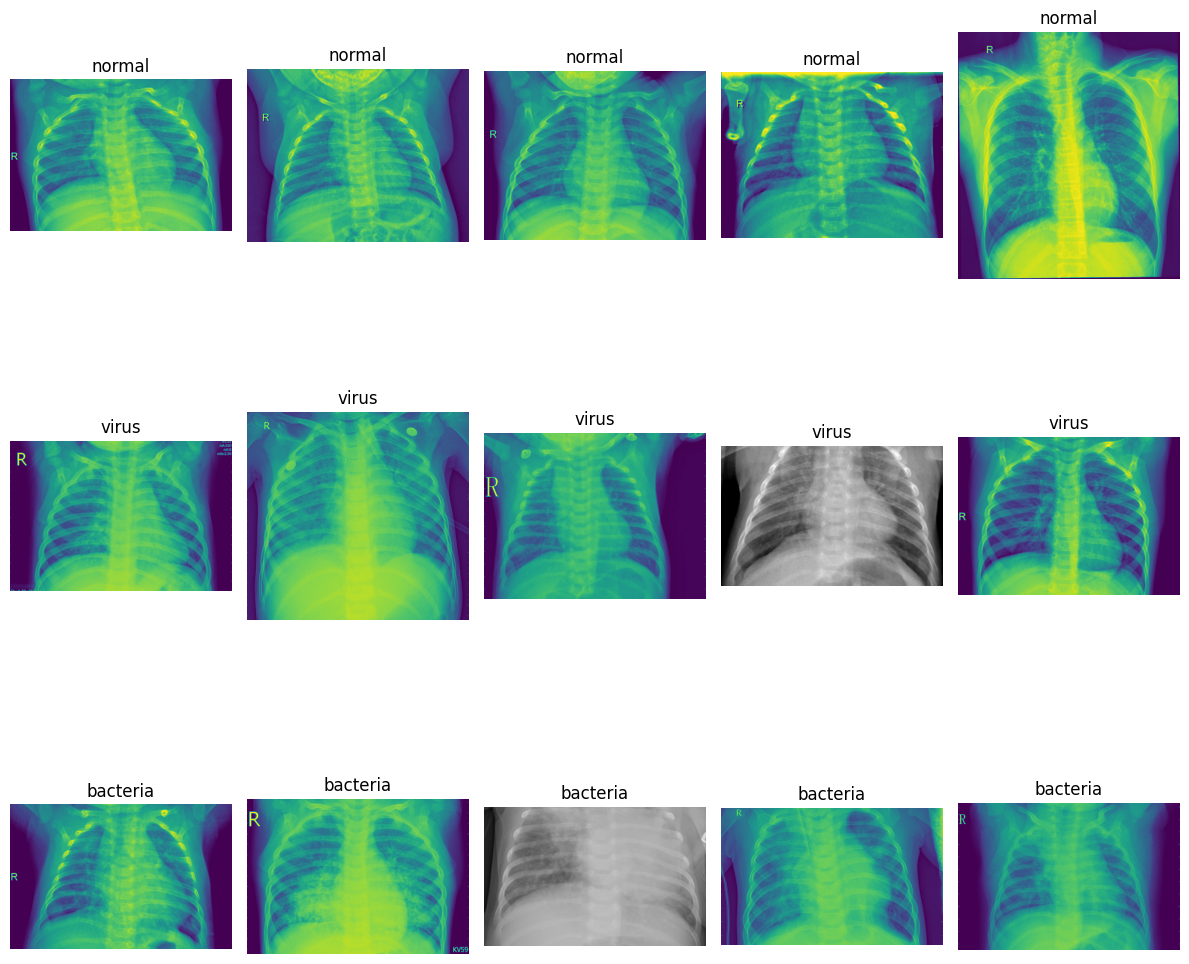

In [6]:
types = train_data['type'].unique()
num_types = len(types)
num_images_per_type = 5

fig, axes = plt.subplots(num_types, num_images_per_type, figsize=(12, 4 * num_types))

for i, type_ in enumerate(types):
    subset = train_data[train_data['type'] == type_].head(num_images_per_type)
    
    for j, (idx, row) in enumerate(subset.iterrows()):
        img_path = row['img_path']
        
        img = mpimg.imread(img_path)
        axes[i, j].imshow(img)
        axes[i, j].set_title(f"{row['type']}")
        axes[i, j].axis('off')
        
        #print(img.size)

plt.tight_layout()
plt.show()

# Dataset classes

In [7]:
class Train_dataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self):
        img_path = self.data["img_path"]
        image = io.imread(img_path)
        y_label = torch.tensor(self.data["label"])


        if self.transform:
            image = self.transform(image)
        return (image, y_label)

In [8]:
class Test_dataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.transform = transform
        self.data=pd.read_csv(csv_file)
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        img_path = self.data["img_path"]
        image = io.imread(img_path)
     
        if self.transform:
            image = self.transform(image)

        return image

In [9]:
train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])])
test_transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                    [0.229, 0.224, 0.225])])


In [10]:
batch_size = 128
dataset = Train_dataset('/kaggle/working/train_labels.csv', transform=train_transform)
train_set_size = int(len(dataset) * 0.8)
print("Train set length: ", train_set_size)
valid_set_size = len(dataset) - train_set_size
print("Validation set length: ", valid_set_size)
train_set, valid_set = torch.utils.data.random_split(dataset, [train_set_size, valid_set_size])
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_set, batch_size=batch_size, shuffle=True)

test_data = Test_dataset('/kaggle/working/test_labels.csv', transform=test_transform)
print("Test set length: ",len(test_data))
test_loader = DataLoader(test_data, batch_size=batch_size)

Train set length:  4185
Validation set length:  1047
Test set length:  624
